Infections

Broken out by severe infections (hospitalizations) vs. non-severe

Broken out by subpopulations in model

UG residence halls

UG off-campus

Grad student research-focused

Grad student class-focused

Staff / faculty student-focused

Staff / faculty on-campus, not student-focused

Staff / faculty off-compus

Non-Cornell Tompkins County

Quarantine space

Hotel rooms occupied

Hotel rooms remaining

Number of on-campus students quarantined

Number of students isolated

Number of off-campus students quarantined


In [1]:
fnames = "fs_non_student.csv  fs_off.csv  fs_student.csv  gs_class.csv  gs_research.csv  ithaca.csv  ug_high.csv  ug_low.csv".strip().split()


In [2]:
import pandas as pd

def process_csvs(nominal_folder):
    nom_sims = []
    # read the csvs
    for idx in range(50):
        subfolder = nominal_folder + str(idx) 
        sim_results = {}
        for fname in fnames:
            sim_results[fname.split('.')[0]] = pd.read_csv(subfolder + "/" + fname)
        nom_sims.append(sim_results)

    # average all the dfs
    avg_sims = nom_sims[0]
    for idx in range(1,50):
        for key in avg_sims:
            avg_sims[key] = avg_sims[key].add(nom_sims[idx][key])

    for key in avg_sims:
        avg_sims[key] = avg_sims[key].divide(50)

    # make the new df

    avg_nominal = pd.DataFrame()

    for key in avg_sims:
        avg_nominal['{}_cumulative_symptomatic'.format(key)] = avg_sims[key][['severity_1', 'severity_2', 'severity_3']].sum(axis=1)
        avg_nominal['{}_cumulative_hospital'.format(key)] = avg_sims[key][['severity_2', 'severity_3']].sum(axis=1)
        avg_nominal['{}_cumulative_infections'.format(key)] = avg_sims[key][['severity_0', 'severity_1', 'severity_2', 'severity_3']].sum(axis=1)
        avg_nominal['{}_susceptible'.format(key)] = avg_sims[key]['S']
    
    return avg_nominal

In [3]:
nominal_folder = "aug_10_sim_results/nominal/"
avg_nominal = process_csvs(nominal_folder)

In [4]:
opt_folder = "aug_10_sim_results/optimistic/"
avg_optimistic = process_csvs(opt_folder)

In [5]:
pess_folder = "aug_10_sim_results/pessimistic/"
avg_pessimistic = process_csvs(pess_folder)

In [17]:
# collapse dataframe for semester output, only keep the infection columns with daily false positives added

def get_infections_only(big_df):
    
    # first get infections and susceptibles
    infections = pd.DataFrame()
    for i in range(len(big_df.columns)):
        if 'infections' in big_df.columns[i]:
            infections[big_df.columns[i]] = big_df[big_df.columns[i]]
        elif 'susceptible' in big_df.columns[i]:
            infections[big_df.columns[i]] = big_df[big_df.columns[i]]
            
    # then add daily FPs to each group: FP = test_frac * FPR * susceptibles     
    for group in ['ug_high', 'ug_low', 'gs_class']:
        infections[group+'_cumulative_infections'] += 2/7 * 0.001 * infections[group+'_susceptible']
    for group in ['gs_research', 'fs_student', 'fs_non_student']:
        infections[group+'_cumulative_infections'] += 1/7 * 0.001 * infections[group+'_susceptible']
    infections['fs_off_cumulative_infections'] += 1/30 * 0.001 * infections['fs_off_susceptible']

    
    # generate data frame to store infections by group (4 groups)
    group_inf = pd.DataFrame()
    quantity = 'cumulative_infections'
    
    group_inf['fs_'+quantity] = infections['fs_non_student_'+quantity] \
                                         + infections['fs_off_'+quantity] + infections['fs_student_'+quantity]
    group_inf['gs_'+quantity] = infections['gs_class_'+quantity] + infections['gs_research_'+quantity]
    group_inf['ug_'+quantity] = infections['ug_high_'+quantity] + infections['ug_low_'+quantity]
    group_inf['ithaca_'+quantity] = infections['ithaca_'+quantity]
    
    
    return group_inf

In [18]:
avg_inf_semester_nominal = get_infections_only(avg_nominal)
avg_inf_semester_optimistic = get_infections_only(avg_optimistic)
avg_inf_semester_pessimistic = get_infections_only(avg_pessimistic)

In [19]:
avg_inf_semester_nominal

,fs_cumulative_infections,gs_cumulative_infections,ug_cumulative_infections,ithaca_cumulative_infections
0,1.144848,2.107286,4.526000,2.34
1,3.044507,5.446611,11.483634,9.66
2,5.764111,8.825349,17.939274,21.28
3,8.043673,11.663871,24.095257,33.52
4,10.423231,13.502489,29.111389,44.58
...,...,...,...,...
108,115.546331,95.338717,488.423526,280.10
109,116.166318,95.978754,492.482411,282.00
110,116.886109,96.638483,496.141817,283.62
111,117.646073,97.058311,499.900783,285.14


In [9]:
# add gateway testing infections (interpolated) to the trajectory

import numpy as np

phase_lengths = [3, 11, 17]

UG_frac = [0.5, 0.65]


# rows{phases} x cols{opt, nom, pess}

phase_1a_infections = np.matrix([
    [76,100,124],
    [0,0,0],
    [0,0,0]
])

phase_1b_infections = np.matrix([
    [10*3/14,13*3/14,18*3/14],
    [10*11/14,13*11/14,18*11/14],
    [0,0,0]
])

phase_2a_infections = np.matrix([
    [0,0,0],
    [95,95,95],
    [0,0,0]
])

phase_2b_infections = np.matrix([
    [0,0,0],
    [0,0,0],
    [139, 174, 259]
])

In [10]:
# get interpolation counts from gateway testing

def get_inf_gateway(scenario):
    UG_inf = []
    grad_inf = []
    FS_inf = [0]*31
    ithaca_inf = [233]*31
    
    for phase in range(3):
        length = phase_lengths[phase]
        
        UG_increment = 0
        grad_increment = 0
        
        # compute daily increment 
        for infections in [phase_1a_infections, phase_1b_infections]:
            UG_increment += infections[phase, scenario] * UG_frac[0] / length
            grad_increment += infections[phase, scenario] * (1-UG_frac[0]) / length
        for infections in [phase_2a_infections, phase_2b_infections]:
            UG_increment += infections[phase, scenario] * UG_frac[1] / length
            grad_increment += infections[phase, scenario] * (1-UG_frac[1]) / length
                
        
        # get cumulative count from end of last phase
        if phase>0:
            UG_previous_inf = UG_inf[-1]
            grad_previous_inf = grad_inf[-1]
        else:
            UG_previous_inf, grad_previous_inf = 0,0
        
        # add cumulative infections in this phase
        UG_inf.extend([UG_previous_inf+UG_increment*i for i in range(1,length+1)])
        grad_inf.extend([grad_previous_inf+grad_increment*i for i in range(1,length+1)])
            
            
    gateway_inf = pd.DataFrame({
        'fs_cumulative_infections': FS_inf,
        'gs_cumulative_infections': grad_inf,
        'ug_cumulative_infections': UG_inf,
        'ithaca_cumulative_infections': ithaca_inf
    })
    
    return gateway_inf

In [11]:
inf_gateway_optimistic = get_inf_gateway(0)
inf_gateway_nominal = get_inf_gateway(1)
inf_gateway_pessimistic = get_inf_gateway(2)

In [20]:
# get end-of-gateway-testing / start-of-semester infection numbers

inf_gateway_end_optimistic = list(inf_gateway_optimistic.iloc[-1,])
inf_gateway_end_nominal = list(inf_gateway_nominal.iloc[-1,])
inf_gateway_end_pessimistic = list(inf_gateway_pessimistic.iloc[-1,])

col_names = ['fs_cumulative_infections', 'gs_cumulative_infections', 'ug_cumulative_infections', 'ithaca_cumulative_infections']


# add to the start of semester sim results
for i in range(4):
    avg_inf_semester_nominal[col_names[i]] += inf_gateway_end_nominal[i]
    avg_inf_semester_optimistic[col_names[i]] += inf_gateway_end_optimistic[i]
    avg_inf_semester_pessimistic[col_names[i]] += inf_gateway_end_pessimistic[i]




In [21]:
overall_inf_nominal = pd.concat([inf_gateway_nominal, avg_inf_semester_nominal])
overall_inf_optimistic = pd.concat([inf_gateway_optimistic, avg_inf_semester_optimistic])
overall_inf_pessimistic = pd.concat([inf_gateway_pessimistic, avg_inf_semester_pessimistic])

overall_inf_nominal = overall_inf_nominal.reset_index()
overall_inf_optimistic = overall_inf_optimistic.reset_index()
overall_inf_pessimistic = overall_inf_pessimistic.reset_index()

In [22]:
overall_inf_nominal.to_csv('nominal_trajectory.csv')
overall_inf_optimistic.to_csv('optimistic_trajectory.csv')
overall_inf_pessimistic.to_csv('pessimistic_trajectory.csv')

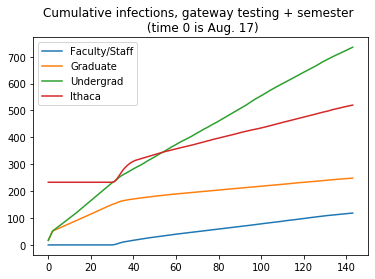

In [23]:
import matplotlib.pyplot as plt

plt.plot(overall_inf_nominal['fs_cumulative_infections'], label='Faculty/Staff')
plt.plot(overall_inf_nominal['gs_cumulative_infections'], label='Graduate')
plt.plot(overall_inf_nominal['ug_cumulative_infections'], label='Undergrad')
plt.plot(overall_inf_nominal['ithaca_cumulative_infections'], label='Ithaca')

plt.title('Cumulative infections, gateway testing + semester \n (time 0 is Aug. 17)')
plt.legend()

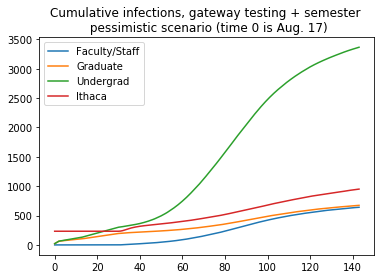

In [24]:
plt.plot(overall_inf_pessimistic['fs_cumulative_infections'], label='Faculty/Staff')
plt.plot(overall_inf_pessimistic['gs_cumulative_infections'], label='Graduate')
plt.plot(overall_inf_pessimistic['ug_cumulative_infections'], label='Undergrad')
plt.plot(overall_inf_pessimistic['ithaca_cumulative_infections'], label='Ithaca')

plt.title('Cumulative infections, gateway testing + semester \n pessimistic scenario (time 0 is Aug. 17)')
plt.legend()

In [ ]:



Average Student Isolations
Average 
Student Quarantines in On-Campus Dorms 
(and fraternities and sororities)
Average
Student Quarantines in Off-Campus Housing (excluding fraternities/sororities, including on-campus non-dorm)
Optimistic / Nominal / Pessimistic
Opt
Nom
Pess
Opt
Nom
Pess
Opt
Nom
Pess
Phase 1 (14-day mandatory self-quarantine period)
86 (includes 76 due to positives in gateway testing)
113 (includes 100 due to positives in gateway testing)
142 (includes 124 due to positives in gateway testing)
N/A
N/A
N/A
24
60
1201
Phase 2
(move-in weekend + 18 days after)
234 (includes 95 due to positives in gateway testing, 88 false positives)
269 (includes 95 due to positives in gateway testing, 88 false positives)
354 (includes 95 due to positives in gateway testing, 88 false positives)
104
(includes 90 due to contact tracing from false positives)
231
(includes 180 due to contact tracing from false positives)
446
(includes 271 due to contact tracing from false positives)
222
(includes 187 due to contact tracing from false positives)
508
(includes 373 due to contact tracing from false positives)
962
(includes 560 due to contact tracing from false positives)
Phase 3 (steady state)
81 (includes 69 false positives)
132 (includes 69 false positives)
509 (includes 69 false positives)
2
+70 due to contact tracing from false positives
55
+140 due to contact tracing from false positives
586
+210 due to contact tracing from false positives
5
+145 due to contact tracing from false positives
79
+290 due to contact tracing from false positives
950
+435 due to contact tracing from false positives


In [43]:
import numpy as np
student_isolations =np.matrix([
    [86,113,142],
    [234,269,354],
    [81,132,509]
])

on_campus_quarantines = np.matrix([
    [0,0,0],
    [104,231,446],
    [2+70,55+140,586+210]
])

off_campus_quarantines = np.matrix([
    [24,60,1201],
    [222,508,962],
    [5+145,79+290,950+435]
])

In [47]:
def get_quarantine_df(scenario):
    phase_lengths = [14, 20, 112-20]

    isos = []
    on_campus_qs = []
    off_campus_qs = []
    hotel_usage = []

    for phase in range(3):
        length = phase_lengths[phase]
        isos.extend([student_isolations[phase,scenario]] * length)
        on_campus_qs.extend([on_campus_quarantines[phase,scenario]] * length)
        off_campus_qs.extend([off_campus_quarantines[phase,scenario]] * length)

    quarantine_df = pd.DataFrame({
        'student_isolations': isos,
        'on_campus_student_quarantines': on_campus_qs,
        'off_campus_student_quarantines': off_campus_qs
    })
    quarantine_df['hotel_usage'] = quarantine_df[['student_isolations','on_campus_student_quarantines']].sum(axis=1)
    return quarantine_df

In [48]:
opt_quarantine_df = get_quarantine_df(0)
nom_quarantine_df = get_quarantine_df(1)
pes_quarantine_df = get_quarantine_df(2)

In [51]:
opt_quarantine_df.to_csv("optimistic_quarantines.csv")
nom_quarantine_df.to_csv("nominal_quarantines.csv")
pes_quarantine_df.to_csv("pessimistic_quarantines.csv")

In [49]:
nom_quarantine_df

,off_campus_student_quarantines,on_campus_student_quarantines,student_isolations,hotel_usage
0,60,0,113,113
1,60,0,113,113
2,60,0,113,113
3,60,0,113,113
4,60,0,113,113
5,60,0,113,113
6,60,0,113,113
7,60,0,113,113
8,60,0,113,113
9,60,0,113,113


In [50]:
pes_quarantine_df

,off_campus_student_quarantines,on_campus_student_quarantines,student_isolations,hotel_usage
0,1201,0,142,142
1,1201,0,142,142
2,1201,0,142,142
3,1201,0,142,142
4,1201,0,142,142
5,1201,0,142,142
6,1201,0,142,142
7,1201,0,142,142
8,1201,0,142,142
9,1201,0,142,142


In [45]:
on_campus_quarantines[0,2]

0

In [46]:
quarantine_df

,off_campus_student_quarantines,on_campus_student_quarantines,student_isolations,hotel_usage
0,24,0,86,86
1,24,0,86,86
2,24,0,86,86
3,24,0,86,86
4,24,0,86,86
5,24,0,86,86
6,24,0,86,86
7,24,0,86,86
8,24,0,86,86
9,24,0,86,86


In [33]:
length

92

In [34]:
isos

[1204, 2260, 13064]